<h2><b>Impact on Accuracy due to Data Augmentation with Generative Adversial Networks (GAN)</b></h2>
<p>Team Members: Ayush Adhikari, Tyler Sargent</p>
<hr>

<p>This notebook accomplishes the goal we set in our project proposal of using GANs to augment data that can be used in addition to the original dataset. Doing so, we hypothesized that the accuracy would increase due to an addition of data, which increase variance in the data and help the classifier more effectively identify the complexities and relationships of features in the data. As we are using two dataset, the both of us took responsibility for one of the datasets and followed the same procedure; Ayush was responsible for the credit fraud dataset and its reports while Tyler was responsible for the loan prediction dataset and its reports. Through the next cells and comments, we will explore the datasets used for this project, processing the data, out choices on methodology, building the GAN model, testing the generated data, and testing the accuracy after adding the data to the original dataset.</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#run once to download data
%pip install kaggle#use to install kaggle module
!mkdir -p ~/.kaggle#might not work trough cell, use terminal
# before running the code below, make sure to download Kaggle API Token first and change path to where the file was downloaded
!mv /path/to/downloaded/kaggle.json ~/.kaggle/#might not work trough cell, use terminal

!kaggle datasets download -d nelgiriyewithana/credit-card-fraud-detection-dataset-2023
!kaggle datasets download -d altruistdelhite04/loan-prediction-problem-dataset

import zipfile
with zipfile.ZipFile('credit-card-fraud-detection-dataset-2023.zip', 'r') as zip_ref:
    zip_ref.extractall('credit-card-fraud-detection-dataset')
with zipfile.ZipFile('loan-prediction-problem-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('loan-prediction-problem-dataset')
!del credit-card-fraud-detection-dataset-2023.zip #windows command, use rm for linux
!del loan-prediction-problem-dataset.zip #windows command, use rm for linux

In [2]:
#data loader methods
from sklearn.preprocessing import StandardScaler
    
def load_credit_fraud():
    #deleting the 1st col as it is just the id; X is 1-30 and y is col 31
    X = pd.read_csv('credit-card-fraud-detection-dataset/creditcard_2023.csv', usecols=range(1,31)).values
    
    #selecting only 5000 of data with labels 0 and 5000 with labels 1
    #splitting data by label
    indices_0 = X[X[:,-1] == 0]
    indices_1 = X[X[:,-1] == 1]
    
    #randomly selecting indices for labels
    random_indices_0 = np.random.choice(indices_0.shape[0], size=5000, replace=False)
    random_indices_1 = np.random.choice(indices_1.shape[0], size=5000, replace=False)

    #creating 2 subsets with 0 and 1
    subset_0 = indices_0[random_indices_0]
    subset_1 = indices_1[random_indices_1]

    #combining both to create one and shuffling
    data = np.vstack((subset_0, subset_1))
    np.random.shuffle(data)

    return (data[:,:-1], data[:,-1].astype(int))


def load_loan_prediction():
    data = pd.read_csv('loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv', usecols=range(1,13))
    data = np.array(data)

    #One hot encoding   
    y = data[:,-1]
    X = data[:,:-1]

    y[y=='Y'] = 1
    y[y=='N'] = 0

    X[X=='Male'] = 1
    X[X=='Female'] = 0

    X[X=='Yes'] = 1
    X[X=='No'] = 0

    X[X=='0'] = 0
    X[X=='1'] = 1
    X[X=='2'] = 2
    X[X=='3+'] = 3

    X[X=='Graduate'] = 1
    X[X=='Not Graduate'] = 0

    X[X=='Rural'] = 0
    X[X=='Semiurban'] = 1
    X[X=='Urban'] = 2

    #Dropping all nan values and changing to ints
    X = X.astype(float)
    y = y[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
    X = X.astype(int)
    y = y.astype(int)

    return X, y

<p>We wanted to use two datasets for this project as it would allow more variability between the tests. Our main goal was to see how the generated data would be affected by the size of the original dataset. Therefore, we choose to use the fraud_detection dataset that has approximately 570,000 samples along with the loan_detection dataset that has 615 samples. The function defined in the cell above are data loaders for the two datasets. The first function reads in the fraud dataset as a pandas array. We chose to read only columns 1 through 31 as the 1st (0th) column was the id of the credit transaction. We did not think this would be helpful for the classification. Given that the data is so expansive, we did not have the capabilities to run the entire fraud dataset. Just calculating the baseline accuracies were taking more than 5 hours, so we decided that 10,000 samples would be good for our large dataset, considering that the smaller one ended up being 20x smaller in size. We, therefore, chose to select 10,000 samples randomly from the dataset, with 5,000 of label 0 and 5,000 of label 1. This was to ensure that the dataset was balanced. We added the two subsets of data together and shuffled it. The datasets and labels associated with each sample is returned as (X,y). All of the values were already continuous and processed well. Therfore, there was no need to drop n/a values or preprocess the daat. We acknowledge that using only a subset of the data might not capture the entirety of the data and affect that performace of the classifier, but we had to do this to ensure we could actually finish the project. The second function is for the loan_prediction dataset. For this dataset also, we did not use the first column because it was related to the id and not helpful to the project. Compared to the other dataset, this one had a lot of categorical features; we changed all of these to numerical values using one hot encoding. There were also some nan values that we dropped. The resulting dataset contained 480 samples, which was enough for a comparison to the large dataset.</p>

In [3]:
#Loading data
X_loan, y_loan = load_loan_prediction()
X_fraud, y_fraud = load_credit_fraud()

#Standardizing data: Fraud
X_fraud = StandardScaler().fit_transform(X_fraud)
#Standardizing data: Loan
#scale only columns [5,6,7,8] as the others are binary or ordinal features
X_loan[:,5] = (X_loan[:,5] - (np.mean(X_loan[:,5], axis=0))) / (np.std(X_loan[:,5], axis=0))
X_loan[:,6] = (X_loan[:,6] - (np.mean(X_loan[:,6], axis=0))) / (np.std(X_loan[:,6], axis=0))
X_loan[:,7] = (X_loan[:,7] - (np.mean(X_loan[:,7], axis=0))) / (np.std(X_loan[:,7], axis=0))
X_loan[:,8] = (X_loan[:,8] - (np.mean(X_loan[:,8], axis=0))) / (np.std(X_loan[:,8], axis=0))

In [5]:
#Checking if data is valid
def data_is_valid(X,y, examples, features):
    return {
        X.shape == (examples, features)
        and y.shape == (examples,)
        and not np.any(np.isnan(X))
        and np.all((y==1) | (y==0))
    }
print(f'Validity for Credit Risk Dataset: {data_is_valid(X_loan, y_loan, 480, 11)}')
print(f'Validity for Credit Fraud Dataset: {data_is_valid(X_fraud, y_fraud, 10000, 29)}')

Validity for Credit Risk Dataset: {True}
Validity for Credit Fraud Dataset: {True}


<p>We used the data loaders to get both of the datasets as X and y paris. The X contains all of the data after being preprocessed and the y contains the labels. As we described above, both datasets were processed so they could work with classifiers. As the next step, we wanted to standardize the data so it would be more efficent for classification. The fraud dataset contains all continuous values, but the values have a wide range. Therefore, we thought it made sense to standardize the entire dataset so it could be centered around the mean. The loan dataset was different as most of the data were binary or ordinal. Therefore, we only selected the features with the wide range of values and standardized them; these were columns 5, 6, 7, and 8. We verified that the data was loaded correctly with the shape we wanted with the data_is_valid() function.</p>

In [4]:
#import libraries for calculating accuracies
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm

In [12]:
#param grids for classifiers
svc_param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['rbf']}
#setting cv
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [7]:
#Cell for calculating base accuracies of the credit fraud datatset
classifier_1 = GridSearchCV(svm.SVC(), svc_param_grid, cv=cv)
classifier_1.fit(X_fraud, y_fraud)
fraud_svc_accuracy = np.mean(cross_val_score(classifier_1, X_fraud, y_fraud, cv=cv, scoring='accuracy'))

In [8]:
print(f'Parameters to use for the fraud dataset (SVC): {classifier_1.best_params_}')

Parameters to use for the fraud dataset (SVC): {'C': 100, 'kernel': 'rbf'}


In [9]:
#Cell for calculating base accuracies of the loan prediction datatset
#svc classifier
classifier_1 = GridSearchCV(svm.SVC(), svc_param_grid)
classifier_1.fit(X_loan, y_loan)
loan_svc_accuracy = np.mean(cross_val_score(classifier_1, X_loan, y_loan, cv=cv, scoring='accuracy'))

In [10]:
print(f'Parameters to use for the fraud dataset (SVC): {classifier_1.best_params_}')

Parameters to use for the fraud dataset (SVC): {'C': 1, 'kernel': 'rbf'}


In [12]:
base_accuracies = [
    [loan_svc_accuracy],
    [fraud_svc_accuracy]
]
print('Base accuracies using SVC classifier for both datasets:')
pd.DataFrame(base_accuracies, columns=['SVC'], index=['Loan Prediction Dataset', 'Credit Fraud Dataset'])

Base accuracies using SVC classifier for both datasets:


,SVC
Loan Prediction Dataset,0.797917
Credit Fraud Dataset,0.990400


<p>To compare the results of the final tests, we needed a base accuracy. We decided to use cross validation with Grid Search to perform this. For our classifier, we thought that the SVM would be sufficient as it is considered to be one of the best in its category. However, to select hyperparameters, we used 4 different values for C and then tested the best classifier. After performing the later tests, we also realized that we could not use cross validation and select the best hyperparameters, so we decided to print out the optimal hyperparameter used in the baseline accuracy, and use the same ones for the later test. This is was done for both of the datasets, and the acucracies are formatted in the tabel above. The fraud dataset is much larger but also has a nearly perfectly accuracy. We tried using various samples size from the original daatset and most of them resulted in a high accuracy, greater than 95%. For smaller subsets, we saw a decrease, but it was still nearly perfect. We wanted to use the GAN to generate more data and improve accuracy, but it might be difficult to improve on this. Therefore, for this dataset, we wanted to observe the reults of augmenting data and attempt to recreate the same accuracy. On the other hand, there was definitely room for improvement with the loan prediction dataset. Our goal for this dataset was to observe the effects of increasing sample size on accuracy.</p>

In [23]:
#import libraries needed for GAN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
#generator and discriminator functions
def build_generator(latent_dim, output_dim):
    return Sequential([
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, input_dim=latent_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(output_dim, activation='sigmoid')
    ])

def build_discriminator(input_dim):
    return Sequential([
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

def build_gan(generator, discriminator):
    discriminator.trainable = False
    return Sequential([
        generator,
        discriminator
    ])

def train_gan(generator, discriminator, gan, data, latent_dim, epochs, batch_size, verbose):
    generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    for epoch in range(epochs):
        #train discriminator on real data
        real_data = data[np.random.randint(0, data.shape[0], batch_size)]
        real_labels = np.ones((batch_size, 1))

        _ = discriminator.train_on_batch(real_data, real_labels)

        #train discriminator on generated data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise, verbose=verbose)
        fake_labels = np.zeros((batch_size, 1))

        _ = discriminator.train_on_batch(generated_data, fake_labels)

        #train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))

        g_loss, g_acc = gan.train_on_batch(noise, valid_labels)
        
        if verbose:
            print(f"GAN: Epoch {epoch + 1}/{epochs}, Loss: {g_loss}, Accuracy: {g_acc}")
        
def generate_synthetic_data(generator, latent_dim, n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_data = generator.predict(noise, verbose=False)
    return generated_data

def run_gan(data, num_features, num_noise_vector, n_samples, epochs=200, batch_size=10000, verbose=False):
    #scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    #build models
    generator = build_generator(num_noise_vector, num_features)
    discriminator = build_discriminator(num_features)
    gan = build_gan(generator, discriminator)
    
    #train and generate data using GAN
    train_gan(generator, discriminator, gan, scaled_data, num_noise_vector, epochs, batch_size, verbose)
    generated_data = generate_synthetic_data(generator, num_noise_vector, n_samples)
    
    #reverse the scaling on data
    generated_data = scaler.inverse_transform(generated_data)
    
    #return the generated data
    return generated_data

<p>Comments about creating the discriminator, generator, and model; expirementing with hyperparameters (batch_size, epochs, noise vector), scaling data, layers in the model, etc.</p> - Tyler

In [22]:
def calculate_accuracy(X_train, y_train, X_test, y_test, parameter):
    accuracies = []
    for _ in range(5):
        classifier = svm.SVC(C=parameter)
        classifier.fit(X_train, y_train)
        svm_pred = classifier.predict(X_test)
        accuracies.append(np.mean(y_test == svm_pred))
    return sum(accuracies)/5

def train_splits_using_gan(X,y, samples, svc_param, verbose=False):
    accuracy_added = []
    splits = [.75,.50,.25] #train on 75, 50, 25 percent of the dataset

    for split in splits:
        #splitting into train and test of size test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
        
        X_0 = X_train[y_train==0]
        X_1 = X_train[y_train==1]
        
        for sample in samples:
            generated_data_0 = run_gan(X_0, X_0.shape[1], 256, sample, verbose=verbose)
            generated_data_1 = run_gan(X_1, X_1.shape[1], 256, sample, verbose=verbose)
            
            combined_generated_data = list(zip(generated_data_0, np.zeros(len(generated_data_0)))) + list(zip(generated_data_1, np.ones(len(generated_data_1))))
            np.random.shuffle(combined_generated_data)
            X_generated, y_generated = zip(*combined_generated_data)
            X_generated = np.array(X_generated)
            y_generated = np.array(y_generated)
            
            #calculate accuracy after appending to the original array
            combined_X = np.vstack((X_train,X_generated))
            combined_y = np.concatenate((y_train,y_generated))
            svc_acc = calculate_accuracy(combined_X, combined_y, X_test, y_test, svc_param)
            accuracy_added.append([split, sample*2, (sample*2+len(X)), svc_acc])
            
    return (accuracy_added)

def test_generated_data(X, y):
    X_0 = X[y==0]
    X_1 = X[y==1]
    
    generated_data_0 = run_gan(X_0, X_0.shape[1], 256, X.shape[0]//2)
    generated_data_1 = run_gan(X_1, X_1.shape[1], 256, X.shape[0]//2)
    
    combined_X = np.vstack((generated_data_0,generated_data_1))
    np.random.shuffle(combined_X)
    
    return combined_X

<p>The cell above defines the methods used to generate data to augment and calculate accuracy. The train_splits_using_gans method is used to generate data and test the training and test splits using that and the original data. We wanted to see how the percentage of data used for training used to generate data could impact the quality of generated data. Therefore, we chose to ue a 0.75, 0.50, and 0.25 training and test splits. On the first iteration, 75% will be reserved for testing while only 25% will be used for training. The results of this will be discussed in the next sections. We also wanted to test how the accuracy would change based on the number of generated data sample added to the training set. To set this up, we used an outer loop for the splits and another loop for the num samples generated. Inside the outer loop, we split the data into training and test splits using the value in the splits list. The test set is saved until the end for predicting the accuracy of the classifier, but the training is processed further. We then split the training set by its labels so one subset contains all samples with label 0 and another with samples with containing label 1. We did this after experimenting with feeding data into the GAN model. We could simply just feed the dataset with all the features, X, but we would not know which sample is associated with what label; the generator will simply generate similar data from the data that is fed to it. We also attempted to include the labels as a part of the dataset, for example as the last column of a dataset. However, the problem with this was that the values being returned for that were not binary. They ranged between 0 and 1 rather than being discrete 0 or 1. Thereafter, inside the inner loop, we are running the GAN model on both subsets, each time generating sample number of samples and testing the accuracy on that. We used 256 as the noise vector as that performed the best. After generating data, we know that each subset has a certain label, so we combine both subsets, attach their labels, and shuffle the data to eliminate bias as much as possible. We then concatenated that generated data to the training data and tested the accuracy of predicting on the test set that we reserved. When calculating the base accuracy, we were able to use cross validation, but it was not possible to do that here as we have two different sets. Accordingly, we used the hyperparameter found using GridSearch from the cells above and took an average of 5 accuracies generated by the SVM classifier using the rbf kernel. As we are passing in 5 samples for both datasets, we are repeating this process 15 times, for a total of 30 trails.</p>
<p>The last function defined is test_generated_data. It is used in the cells below to test the quality of data generated. To make sure we are repeating the same process as when we run the tests, we used the same process of splitting the data into subsets of labels 0 and 1. Then we used the GAN model to generate data half the size of the original data received as an argument, X. This would ensure we get half of the samples with label 1 and another with label 0, creating a balanced dataset. We combined them together and shuffled it before returning it.</p>

In [55]:
#testing to see if the generated data is similar to the original data using statistical summaries and correlation coefficients
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(X_fraud, y_fraud, test_size=0.20)

test_similar_fraud = test_generated_data(X_fraud_train, y_fraud_train)
print(f'Statistics for the Fraud dataset:')
print(f'Correlation of Means of Original and Generated: {np.corrcoef(X_fraud_test.mean(0), test_similar_fraud.mean(0))[0,1]}')
print(f'Correlation of Standard Deviations of Original and Generated: {np.corrcoef(X_fraud_test.std(0), test_similar_fraud.std(0))[0,1]}')
correlation_original = np.corrcoef(X_fraud_test, rowvar=False)
correlation_generated = np.corrcoef(test_similar_fraud, rowvar=False)
print(f'Correlation of Correlation Matrices of Original and Generated: {np.corrcoef(correlation_original.flatten(), correlation_generated.flatten())[0,1]}')

Statistics for the Fraud dataset:
Correlation of Means of Original and Generated: 0.25653454492041267
Correlation of Standard Deviations of Original and Generated: 0.18568200753729708
Correlation of Correlation Matrices of Original and Generated: 0.40306058549305807


In [41]:
#testing to see if the generated data is similar to the original data using statistical summaries and correlation coefficients
X_loan_train, X_loan_test, y_loan_train, y_loan_test = train_test_split(X_loan, y_loan, test_size=0.20)

test_similar_loan = test_generated_data(X_loan_train, y_loan_train)
print(f'Statistics for the Loan dataset:')
print(f'Correlation of Means of Original and Generated: {np.corrcoef(X_loan_test.mean(0), test_similar_loan.mean(0))[0,1]}')
print(f'Correlation of Standard Deviations of Original and Generated: {np.corrcoef(X_loan_test.std(0), test_similar_loan.std(0))[0,1]}')
correlation_original = np.corrcoef(X_loan_test, rowvar=False)
correlation_generated = np.corrcoef(test_similar_loan, rowvar=False)
print(f'Correlation of Correlation Matrices of Original and Generated: {np.corrcoef(correlation_original.flatten(), correlation_generated.flatten())[0,1]}')

Statistics for the Loan dataset:
Correlation of Means of Original and Generated: 0.5243049180827493
Correlation of Standard Deviations of Original and Generated: 0.24661273206381765
Correlation of Correlation Matrices of Original and Generated: 0.804194393823393


<p>To test the similarity of the data, we followed a similar approach to testing the actual data. We used the function, test_generated_data(), described above, to generate data and measured the similarity. This was a very difficult task, which might not be entirely accurate, as testing generated data is a field that is not yet fully researched. We also did not find any resources for testing generated data used for classification. A lot of the resources were using GANs to generate images or text, for which there are other methods to test the quality. Therefore, we used correlation coefficients. These measure how similar the data is to one another, which we thought was suitable to this project. We used three different measurements: correlations of mean, standard deviation, and correlation coefficients of each feature. For the generated dataset and the test set, we calculated these measurements along the columns. Then we used correlation coefficients to measure how similar they were. For the 3rd test, we first tested how similar the features to one another in their individual datasets, and then compared how those values correlated with the other dataset. To reiterate, we used this method after researching what would be the best way to measure similarity between datasets and do not think we are completely correct in this approach. There is more to measuring generated data, but as this was not the focus of the project, we went with simple measurements. As you can observe, the coefficients for the loan dataset are very good. A coefficient of 80 implies that the datasets are fairly correlated to one another. We thought it would be enough to generate good data. In contrast, the measurements for the fraud dataset were not so optimal. This might have to do with the hyperparameters utilized in the GAN model or the layers used to build the model, but we left it to see how this would impact the performance of the classifiers.</p>

In [ ]:
#Calculating the accurcies for all splits for both datasets
fraud_acc_added = train_splits_using_gan(X_fraud, y_fraud, [500,1000,2500, len(X_fraud)//2, len(X_fraud)], 100, verbose=True)
#Changing to numpy arrays
fraud_acc_added = np.array(fraud_acc_added)
fraud_added_df = pd.DataFrame(fraud_acc_added, columns=['% Tested','Gen Samples','Total Samples','Accuracy'])
#rounding values so it is displayed better in table
fraud_added_df = fraud_added_df.round(5)

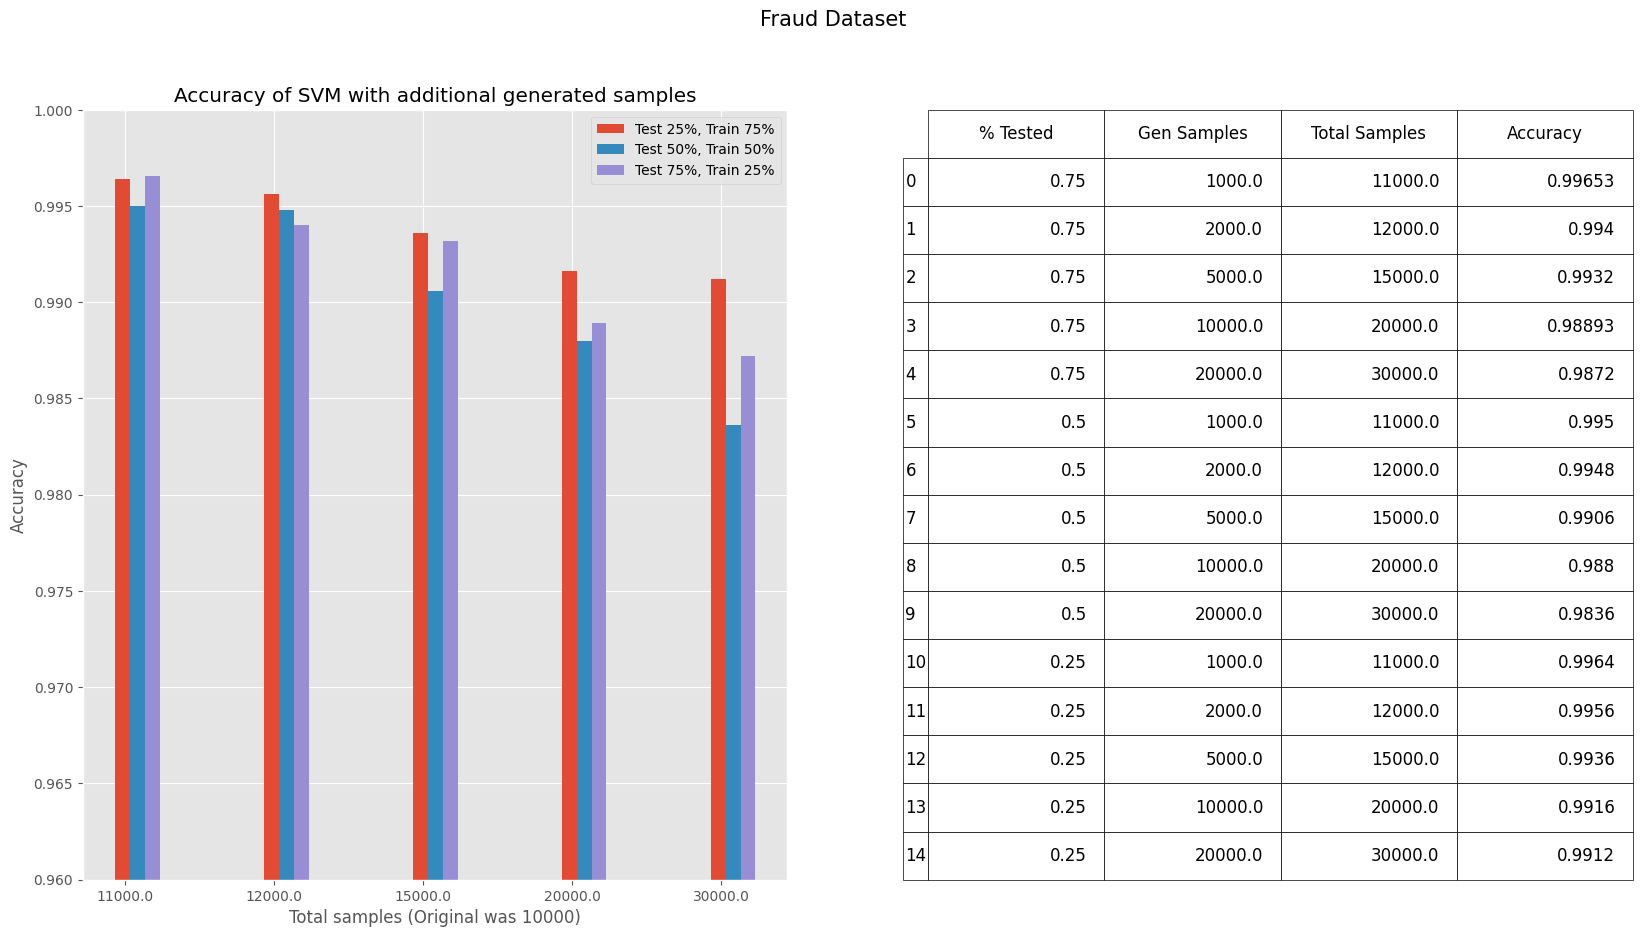

In [15]:
#Visualizing data for the fraud dataset
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,10))
fig.suptitle('Fraud Dataset', fontsize=15)
ax1 = fig.add_subplot(121)

#getting the axes
fraud_categories = np.unique(fraud_acc_added[:,2])
fraud_svm_acc_25 = fraud_acc_added[fraud_acc_added[:,0]==0.25][:,3]
fraud_svm_acc_50 = fraud_acc_added[fraud_acc_added[:,0]==0.50][:,3]
fraud_svm_acc_75 = fraud_acc_added[fraud_acc_added[:,0]==0.75][:,3]

#generating indices for bar groups
bar_width = 0.10
index = np.arange(len(fraud_categories))
#creating the grouped bar chart
ax1.bar(index, fraud_svm_acc_25, bar_width, label='Test 25%, Train 75%')
ax1.bar(index+bar_width, fraud_svm_acc_50, bar_width, label='Test 50%, Train 50%')
ax1.bar(index+(bar_width*2), fraud_svm_acc_75, bar_width, label='Test 75%, Train 25%')
#setting labels and axes
ax1.set_ylim(0.96, 1)
ax1.set_xlabel('Total samples (Original was 10000)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy of SVM with additional generated samples')
ax1.set_xticks(index + bar_width / 5, fraud_categories)
ax1.legend()

#setting dataframe next to the graph
ax2 = fig.add_subplot(122)
ax2.axis('off')
table = ax2.table(cellText=fraud_added_df.values, colLabels=fraud_added_df.columns, rowLabels=fraud_added_df.index, bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)

<p>Comments about results for the fraud dataset; note how % used was not really impactful; accuracy increased as samples increased; compare with the base accuracy; note how the accuracy was similar to the baseline but less, probably due to the quality of generated data we saw in the testing above.</p> - Tyler

In [19]:
loan_acc_added = train_splits_using_gan(X_loan, y_loan, [50,100,250, len(X_loan)//2, len(X_loan)], 1, verbose=False)
loan_acc_added = np.array(loan_acc_added)
loan_added_df = pd.DataFrame(loan_acc_added, columns=['% Tested','Gen Samples','Total Samples','Accuracy'])
loan_added_df = loan_added_df.round(5)

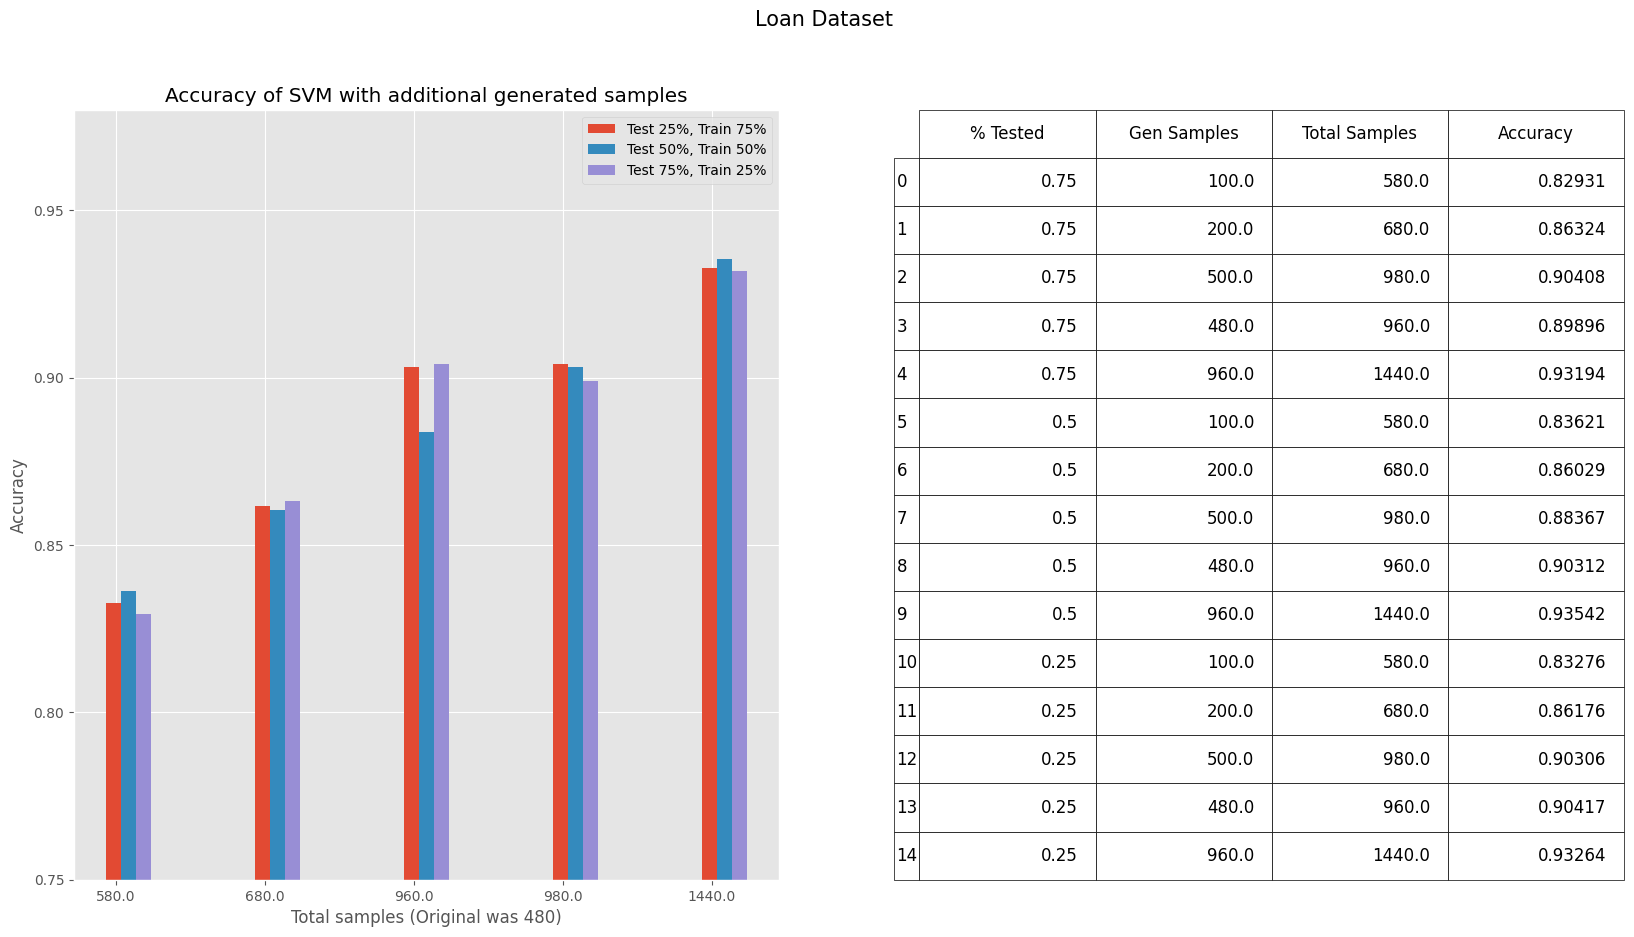

In [20]:
#Visualizing data for the loan dataset
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,10))
fig.suptitle('Loan Dataset', fontsize=15)
ax1 = fig.add_subplot(121)

#getting the axes
loan_categories = np.unique(loan_acc_added[:,2])
loan_svm_acc_25 = loan_acc_added[loan_acc_added[:,0]==0.25][:,3]
loan_svm_acc_50 = loan_acc_added[loan_acc_added[:,0]==0.50][:,3]
loan_svm_acc_75 = loan_acc_added[loan_acc_added[:,0]==0.75][:,3]

#generating indices for bar groups
bar_width = 0.10
index = np.arange(len(loan_categories))
#creating the grouped bar chart
ax1.bar(index, loan_svm_acc_25, bar_width, label='Test 25%, Train 75%')
ax1.bar(index+bar_width, loan_svm_acc_50, bar_width, label='Test 50%, Train 50%')
ax1.bar(index+(bar_width*2), loan_svm_acc_75, bar_width, label='Test 75%, Train 25%')
#setting labels and axes
ax1.set_ylim(0.75,0.98)
ax1.set_xlabel('Total samples (Original was 480)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy of SVM with additional generated samples')
ax1.set_xticks(index + bar_width / 6, loan_categories)
ax1.legend()

#setting dataframe next to the graph
ax2 = fig.add_subplot(122)
ax2.axis('off')
table = ax2.table(cellText=loan_added_df.values, colLabels=loan_added_df.columns, rowLabels=loan_added_df.index, bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)

<p>For the loan dataset, we followed the same approach as testing the fraud dataset. We used the train_splits_using_gan function to calculate the accuracy for 15 combinations of train/test splits and samples generated. The results can be seen above. In the table, the % tested column represents how much of the data was used from the dataset passed in as testing. The remaining is used as the training set. The gen samples represents how many samples were generated for that test; the total sampels represents the generated samples added to the entire dataset and it represents the total number of samples, which include the generated sample, test set, and train set. For example, the original size of the loan dataset was 480 samples. Using 25% as training and the rest as test data, we generate 100 samples. That 100 is added to the training and tested on the 75%. However, the total samples represents the original 480 and the 100 additional data. Therefore, the splits used for prediction are 360 for testing and 120+100 for training. This is true for all other tests as well. The last column, then, represents the accuracy for that split and that many samples generated. Compared to the fraud dataset, we were able to increase the accuracy for the classifier. You can notice in the graph that as the samples increased, the accuracy also increased. The original accuracy we calculated for this dataset as the base was 0.7979. With the addition of data, that accuracy increased to almost 93.5%. The graph follows the trend that we saw using learning curves. As the samples increase, the accuracy of the classifier also increases. It was interesting to note that the splits did not have that much of a drastic effect on the difference in accuracy. We had hypothesized and seen throughout the class that higher training splits might lead to less overfitting and reduced bias as the model can learn better from the data. Accordingly, we expected that the split with the higher training data would perform better. However, that was not really the case . All three splits performed equally as good, and there was variability on which split was the best using some total samples. There are a lot of reasons why this could be the case: the data could be evenly distributed, well-shuffled, simple, or the use of effective hyperparameters when generating data. One reason for the contrast with the fraud dataset could be that the accuracy increased due to the quality of the data generated. We saw in the earlier cells that the generated data for the loan dataset was better correlated with one another. I think this dataset accomplished what we had planned to demonstrate in the project proposal. We augmented data to the dataset using Generative Adversial Netwokrs and saw an incremental increase in accuracy with more samples used for the classification purpose.</p>

<hr>

<p>Closing comment about the project, GANs, resources, other remarks; what you learned; include that not eveything might be accurate due to the complexity of the project and lack of resources on generating training data and testing generated data. Tried our best</p> - Tyler

<h3><u><b>Resources Used</b></u></h3>
<ul>
    <li>https://realpython.com/generative-adversarial-networks/</li>
    <li>https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-gan</li>
    <li>https://medium.com/dida-machine-learning/data-augmentation-with-gans-for-defect-detection-8318fab1a514</li>
    <li>https://www.baeldung.com/cs/ml-gan-data-augmentation</li>
    <li>ChatGPT</li>
    <li>https://www.tensorflow.org/tutorials/generative/dcgan</li>
<ul>